# Plot hurricanes season from track dataset

The goal was to generate a plot similar to the following image (for season 2017) found on the NOAA website (https://www.nhc.noaa.gov/data/tcr/index.php?season=2017&basin=atl). I also wanted to extract hurricane trajectories for another project.

# Tropical Storms data from NOAA

This report updates the original HURDAT documentation to reflect significant changes since 2012 to both the format and content for the tropical cyclones and subtropical cyclones of the **Atlantic basin** (i.e., *North Atlantic Ocean*, *Gulf of Mexico*, and *Caribbean Sea*).

### Best Track Data (HURDAT2) 
http://www.nhc.noaa.gov/data/#hurdat

Atlantic hurricane database (HURDAT2) 1851-2016 (5.9MB download)
This dataset was provided on 11 April 2017 to include the 2016 update to the best tracks.

This dataset (known as Atlantic HURDAT2) has a comma-delimited, text format with six-hourly information on the location, maximum winds, central pressure, and (beginning in 2004) size of all known tropical cyclones and subtropical cyclones.
---

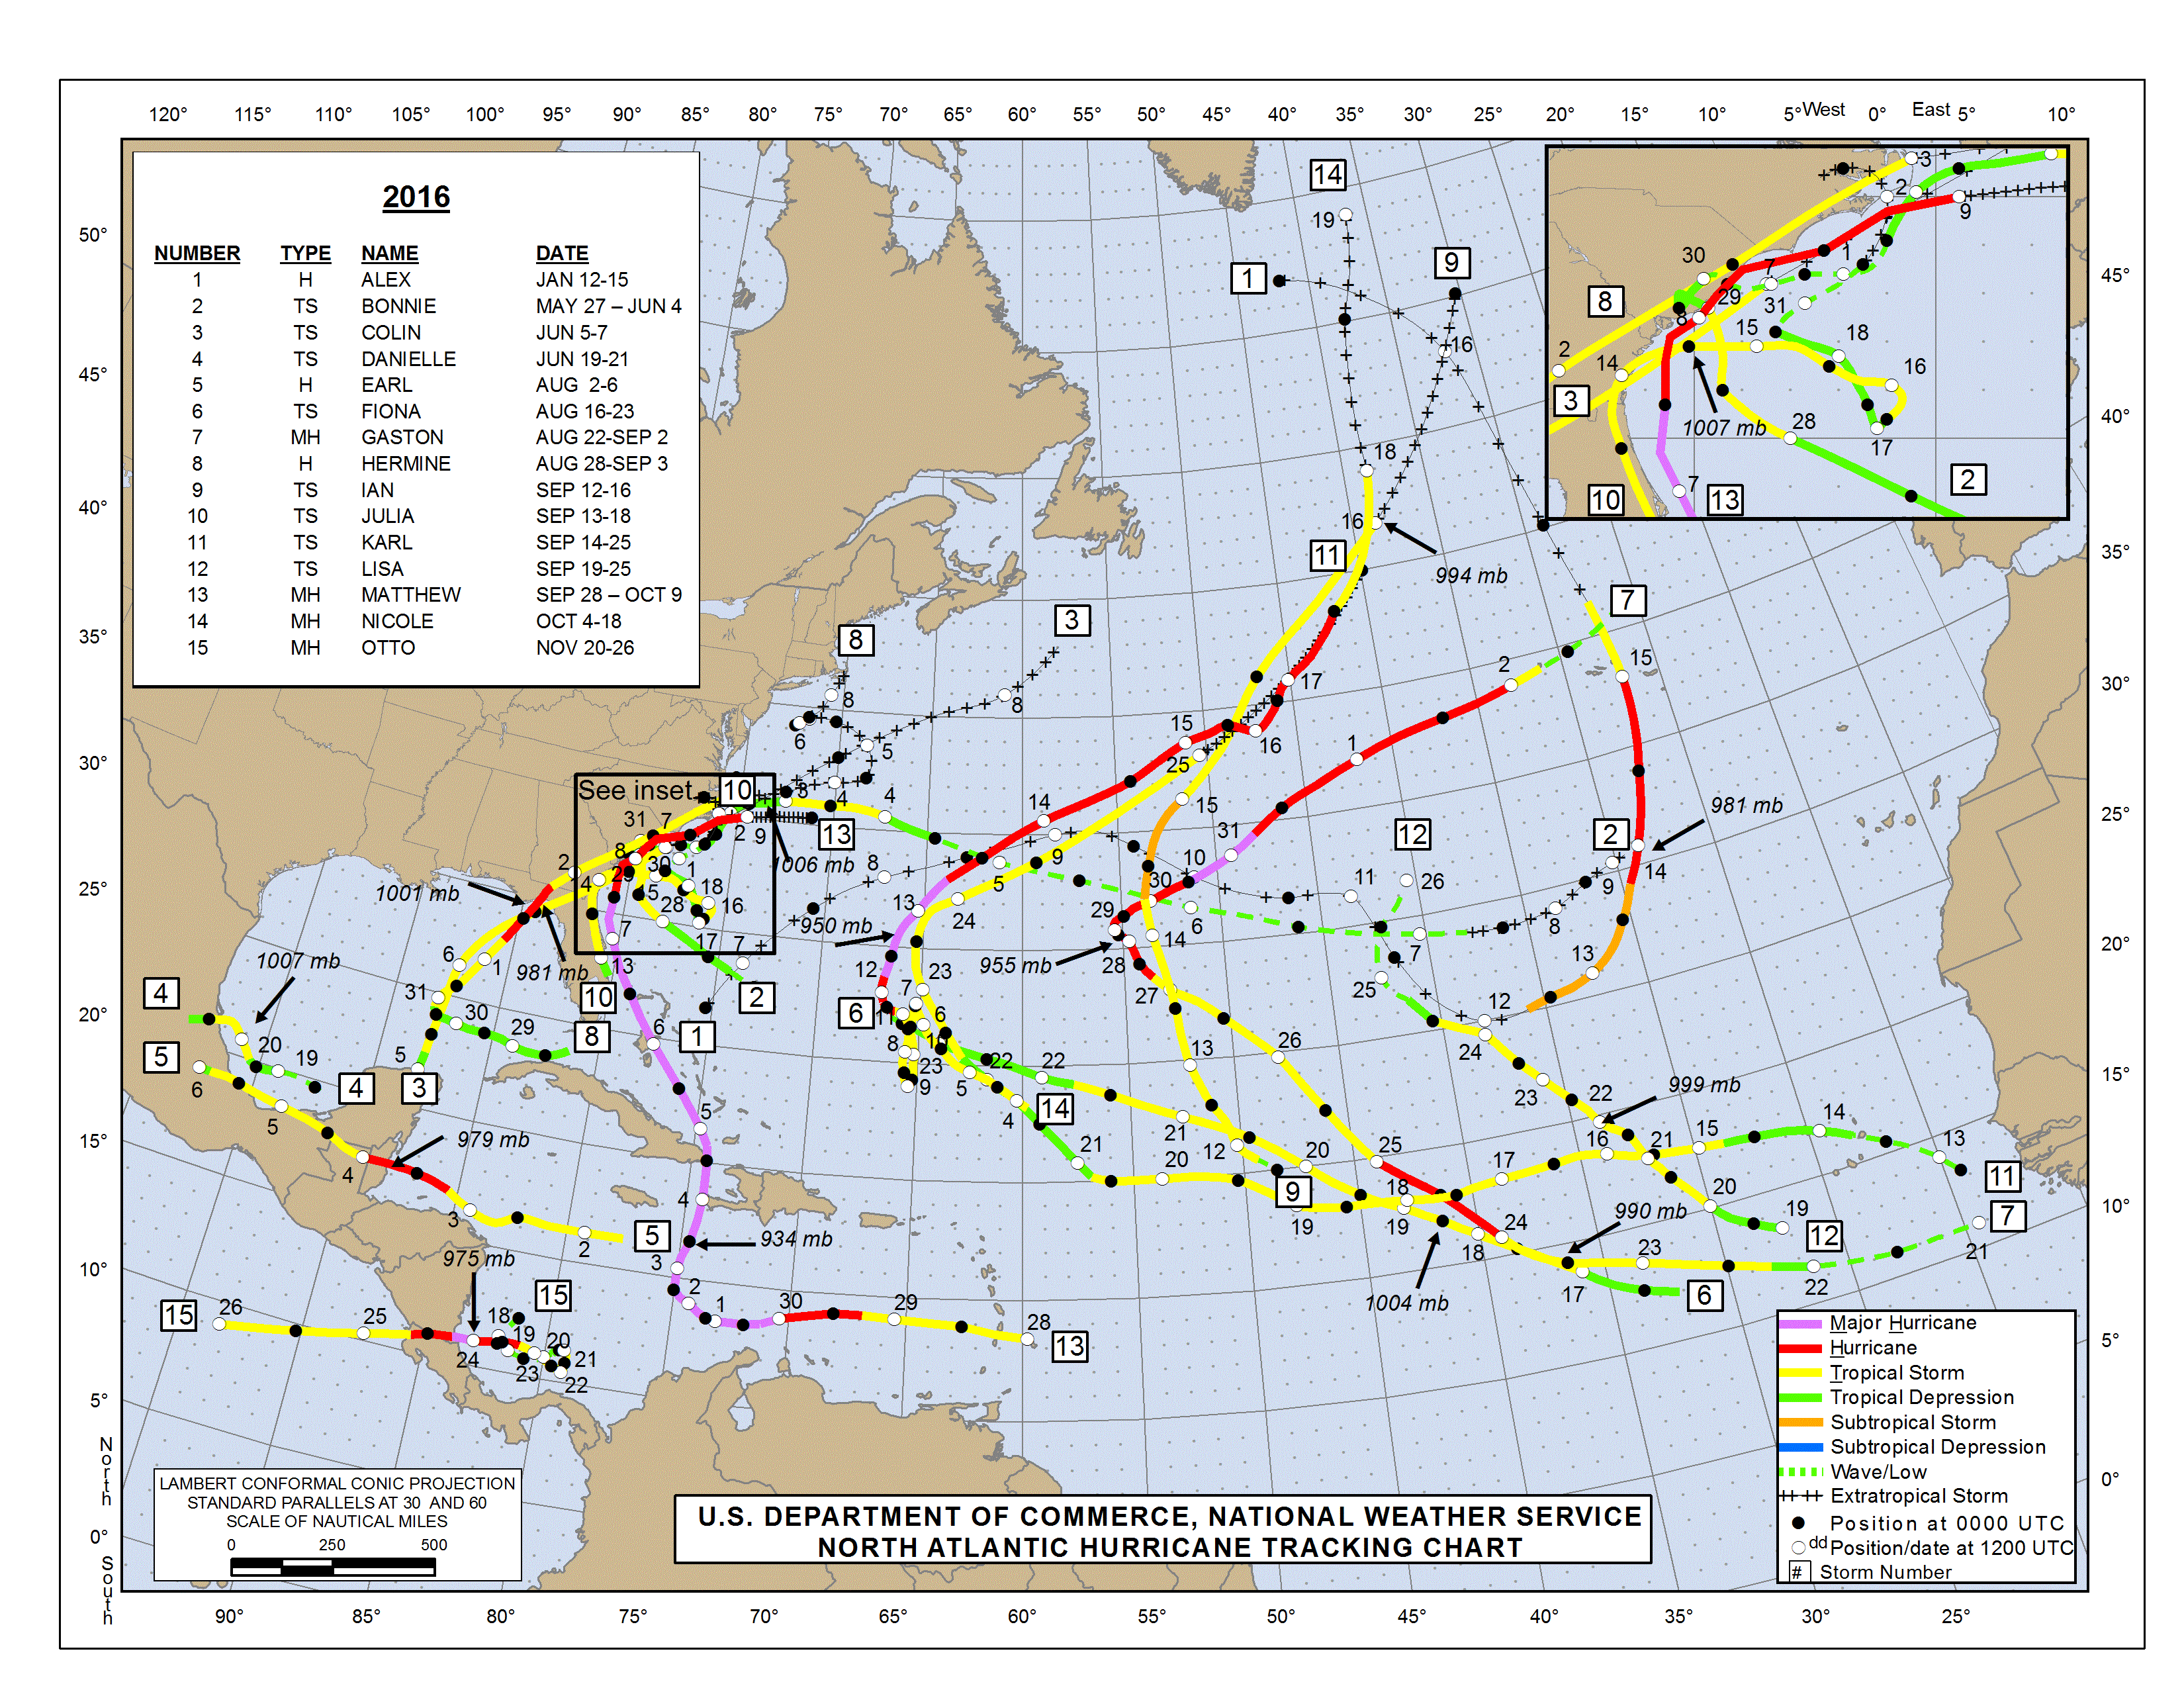

In [1]:
from IPython.display import Image
Image("https://www.nhc.noaa.gov/data/tracks/tracks-at-2016.png")

# File format

## Header line format
AL092011, IRENE, 39,

1. AL: Basin - Atlantic
2. 09: ATCF cyclone number for that year
3. 2011: Year
4. Irene: Name if available otherwise UNNAMED
5. 39: Number of entries for this storm

## Line format

The file is an ASCII file containing XX following columns and every line has the following format:

Ex: 20110828, 0935, L, TS, 39.4N, 74.4W, 60, 959, 230, 280, 160, 110, 150, 150, 80, 30, 0, 0, 0, 0,

1. 20110828 : year month day
2. 0935 : hours minute 
3. L : Record identifier (see notes below)
    - C: Closest approach to a coast, not followed by a landfall G – Genesis
    - I: An intensity peak in terms of both pressure and wind L – Landfall (center of system crossing a coastline)
    - P: Minimum in central pressure
    - R: Provides additional detail on the intensity of the cyclone when rapid changes are underway S – Change of status of the system
    - T: Provides additional detail on the track (position) of the cyclone
    - W: Maximum sustained wind speed
4. TS : Status of system. Options are:
    - TD: Tropical cyclone of tropical depression intensity (< 34 knots)
    - TS: Tropical cyclone of tropical storm intensity (34-63 knots)
    - HU: Tropical cyclone of hurricane intensity (> 64 knots)
    - EX: Extratropical cyclone (of any intensity)
    - SD: Subtropical cyclone of subtropical depression intensity (< 34 knots)
    - SS: Subtropical cyclone of subtropical storm intensity (> 34 knots)
    - LO: A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity) 
    - WV: Tropical Wave (of any intensity)
    - DB: Disturbance (of any intensity)
5. 39.4: Latitude
6. N : Hemisphere – North or South
7. 74.4 : (Spaces 31-35) – Longitude
8. W : Hemisphere – West or East
9. 60: Maximum sustain wind (knots)
10. 959: Minimum Pressure (in millibars)
11. 230: 34 kt wind radii maximum extent in NE quadrant (nmi)
12. 280: 34 kt wind radii maximum extent in SE quadrant (nmi)
13. 160: 34 kt wind radii maximum extent in SW quadrant (nmi)
14. 110: 34 kt wind radii maximum extent in NW quadrant (nmi)
15. 150: 50 kt wind radii maximum extent in NE quadrant (nmi)
15. 150: 50 kt wind radii maximum extent in SE quadrant (nmi)
16. 80: 50 kt wind radii maximum extent in SW quadrant (nmi)
17. 30: 50 kt wind radii maximum extent in NW quadrant (nmi)
18. 0: 64 kt wind radii maximum extent in NE quadrant (nmi)
19. 0: 64 kt wind radii maximum extent in SE quadrant (nmi)
20. 0: 64 kt wind radii maximum extent in SW quadrant (nmi)
21. 0: 64 kt wind radii maximum extent in NW quadrant (nmi)

In [2]:
import requests
import io
import os
import pandas as pd
import numpy as np
from netCDF4 import Dataset
from pathlib import Path
import urllib


from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FuncFormatter
%matplotlib inline

url = 'http://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2016-041117.txt'
rawfile = requests.get(url)
rawfile.raise_for_status()

In [3]:
storm = 0
for line in io.StringIO(rawfile.text).readlines():
    if line[0:2] == 'AL':
        storm += 1
print('There is %d storms in the Atlantic region described in this file.' % storm)

There is 1830 storms in the Atlantic region described in this file.


In [4]:
# The parsing code as been done by @ResidentMario (thanks a lot !!), you can find his repo here:
# https://github.com/ResidentMario/hurdat2/blob/master/notebooks/02---Munging%20Atlantic%20Data.ipynb
# I have added some comments as I was understanding it but it is basically still the same!

# The HURDAT file is a bit of a pain to parse
atlantic_storms = []
parser = {'header': None, 'data': []}
for line in io.StringIO(rawfile.text).readlines():
    if line[:2] == 'AL': #add a new storm
        atlantic_storms.append(parser.copy())
        parser['header'] = line
        parser['data'] = []
    else: # add a new line
        parser['data'].append(line)

# remove first blank entry
del atlantic_storms[0]

In [5]:
list_atlantic_storms = []
for storm_dict in atlantic_storms:
    storm_id, storm_name, storm_entries_n = storm_dict['header'].split(",")[:3]
    # remove hanging newline ('\n'), split fields
    data = [[entry.strip() for entry in datum[:-1].split(",")] for datum in storm_dict['data']]
    frame = pd.DataFrame(data)
    frame['id'] = storm_id
    frame['name'] = storm_name
    list_atlantic_storms.append(frame)

# combine list into one pandas data frame
df_AL_storms = pd.concat(list_atlantic_storms)

# put columns id and name first
df_AL_storms = df_AL_storms.reindex(columns=df_AL_storms.columns[-2:] | df_AL_storms.columns[:-2])

# drop last column (create because line in .csv ends with ,)
df_AL_storms.drop(df_AL_storms.columns[22], axis=1, inplace=True)

In [6]:
# rename the columns with meaningful names
df_AL_storms.columns = ['id', 'name', 'day', 'time', 
             'identifier' , 'status',
             'lat',  'lon', 'wind_kt', 'pressure_mbar',
             '34kt_sw_nmi', '34kt_nw_nmi',
             '34kt_ne_nmi', '34kt_se_nmi',
             '50kt_sw_nmi', '50kt_nw_nmi',
             '50kt_ne_nmi', '50kt_se_nmi',
             '64kt_sw_nmi', '64kt_nw_nmi',
             '64kt_ne_nmi', '64kt_se_nmi'
            ]

In [7]:
# combine day + time = datetime format
df_AL_storms['day'] = pd.to_datetime(df_AL_storms['day'])
df_AL_storms['day'] = df_AL_storms.apply(
        lambda x: x['day'].replace(hour=int(x['time'][:2]), minute=int(x['time'][2:])), axis='columns')
df_AL_storms.rename(columns={'day': 'datetime'}, inplace=True)
del df_AL_storms['time']

In [8]:
df_AL_storms.head()

,id,name,datetime,identifier,status,lat,lon,wind_kt,pressure_mbar,34kt_sw_nmi,...,34kt_ne_nmi,34kt_se_nmi,50kt_sw_nmi,50kt_nw_nmi,50kt_ne_nmi,50kt_se_nmi,64kt_sw_nmi,64kt_nw_nmi,64kt_ne_nmi,64kt_se_nmi
0,AL011851,UNNAMED,1851-06-25 00:00:00,,HU,28.0N,94.8W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,1851-06-25 06:00:00,,HU,28.0N,95.4W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,1851-06-25 12:00:00,,HU,28.0N,96.0W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,1851-06-25 18:00:00,,HU,28.1N,96.5W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,1851-06-25 21:00:00,L,HU,28.2N,96.8W,80,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [9]:
# replace filler value by NaN
df_AL_storms = df_AL_storms.replace(to_replace='-999', value=np.nan)
df_AL_storms = df_AL_storms.replace(to_replace="", value=np.nan)

# remove N, S, W, E and replace with a sign
df_AL_storms['lat'] = df_AL_storms['lat'].map(lambda lat: lat[:-1] if lat[-1] == "N" else "-" + lat[:-1])
df_AL_storms['lon']= df_AL_storms['lon'].map(lambda lon: lon[:-1] if lon[-1] == "E" else "-" + lon[:-1])

# now change to float
for col in [df_AL_storms.columns[5:]]:
    df_AL_storms[col] = df_AL_storms[col].astype(float)

In [10]:
# Download ETOPO1 file if not find in specified folder
folder = os.path.expanduser('~/Documents/data/topography/etopo1/')
url = 'https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/cell_registered/netcdf/ETOPO1_Ice_c_gmt4.grd.gz'
filename = folder + url[91:-3]

if not Path(filename).is_file():
    # gzip file (saved archive 378Mb and decompressed ~900Mb)
    print('Downloading: ' + str(url))
    response = urllib.request.urlopen(url)
    compressed_file = response.read()

    # decompressed
    print('Saving: ' + filename)
    with open(filename, 'wb') as outfile:
        outfile.write(gzip.decompress(compressed_file))

# Retrive topology from ETOPO1
lonmin = -120 ; lonmax = 0
latmin =  0 ; latmax =  70
skip = 5

nc    = Dataset(filename,'r')
elon  = nc.variables['x'][:]
elat  = nc.variables['y'][:]
i0 = np.argmin((lonmin-elon)**2)
i1 = np.argmin((lonmax-elon)**2)
j0 = np.argmin((latmin-elat)**2)
j1 = np.argmin((latmax-elat)**2)
elon = elon[i0:i1]
elat = elat[j0:j1]
ez   = nc.variables['z'][j0:j1,i0:i1]

elon = elon[::skip]
elat = elat[::skip]
ez = ez[::skip, ::skip]
nc.close()

# modify ez to put same height on land and plot it as a constant contour
land = np.copy(ez)
land[land > 0] = 150.
land[land <= 0] = 10.

# plotting function
# add degree °W and °E and remove negative sign
def label_lon(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°E' % (x)
    else:
        return '%d°W' % (-x)

# add °N and °S and remove negative sign
def label_lat(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°N' % (x)
    else:
        return '%d°S' % (-x)

def fix_axes(ax, nx, ny):
    ax.xaxis.set_major_locator(MultipleLocator(nx))
    ax.xaxis.set_major_formatter(FuncFormatter(label_lon))
    ax.yaxis.set_major_locator(MultipleLocator(ny))
    ax.yaxis.set_major_formatter(FuncFormatter(label_lat))

# Plot path for a range of year

In [11]:
# function to plot colored trajectory according to tropical storm category
def segments_color(x, y, status, winds):
    pts = np.array([x, y]).T.reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    
    segs_c = np.array(['           ']*len(status))
    
    # status is HU    
    # Hurricane (red)
    hu = status == 'HU'
    segs_c[hu] = 'red'
    
    # if winds > 96 kn: Major Hurricane (majenta)
    mhu = np.where(winds[hu] >= 96)[0]
    segs_c[mhu] = 'magenta'
    
    # status TS (gold)
    ts = status == 'TS'
    segs_c[ts] = 'gold'
    
    # status TD (lime)
    td = status == 'TD'
    segs_c[td] = 'lime'
    
    # status SS (orange)
    ss = status == 'SS'
    segs_c[ss] = 'darkorange'
    
    # status SD (royalblue)
    sd = status == 'SD'
    segs_c[sd] = 'royalblue'
    
    # status WV (grey) opted no dashed (grey)
    wv = status == 'WV'
    segs_c[wv] = 'grey'
    
    # status EX/LO/DV (black)
    ex = np.logical_or(np.logical_or(status == 'EX', status == 'LO'), status == 'DV')
    segs_c[ex] = 'black'
    
    # if empty 
    segs_c[segs_c == '           '] = 'black'
    return segs, segs_c

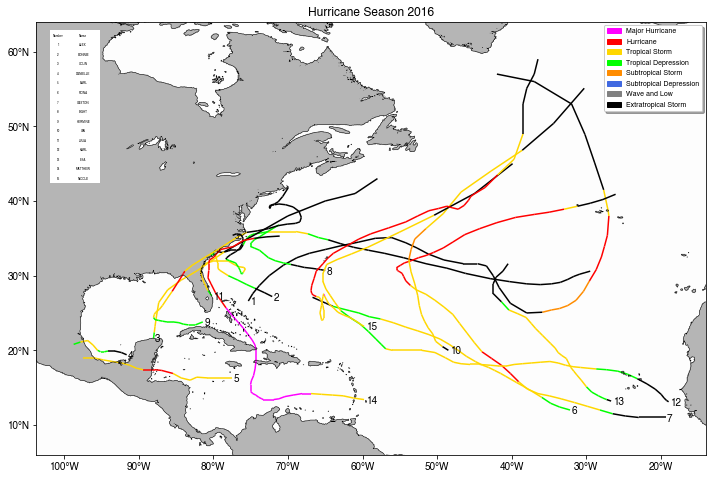

In [12]:
def adjust_range(range_plot, lonmin, lonmax, latmin, latmax):
    if lonmin < range_plot[0]: range_plot[0] = lonmin
    if lonmax > range_plot[1]: range_plot[1] = lonmax
    if latmin < range_plot[2]: range_plot[2] = latmin
    if latmax > range_plot[3]: range_plot[3] = latmax
    return range_plot

from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
year = 2016 # 1851-2016
storms = df_AL_storms[(df_AL_storms.datetime.map(lambda x: x.year) == year) 
                      & (df_AL_storms.lon>lonmin) & (df_AL_storms.lon<lonmax) 
                      & (df_AL_storms.lat>latmin) & (df_AL_storms.lat<latmax)]
fig, ax = plt.subplots(figsize=(12,10))

# can add this for scatter points of trajectories
#storms.plot(kind='scatter', x='lon', y='lat', ax=ax, s=2, c='k')

# loop each storm
rplot = [lonmax, lonmin, latmax, latmin]
segments = np.empty((0,2,2))
norm_wind = np.empty(0)
segments = []
norm_wind = []
storms_text = []
for i, identification in enumerate(np.unique(storms.id)):
    index = storms.id == identification
    name = storms.name[index].values[0].lstrip()
    if len(storms.lat[index].values) > 1:
        x_s = storms.lon[index].values
        y_s = storms.lat[index].values
        status_s = storms.status[index].values
        wind_s = storms.wind_kt[index].values
        s, s_c = segments_color(x_s, y_s, status_s, wind_s)
        segments = LineCollection(s, colors=s_c, linewidths=1.5)
        ax.add_collection(segments)
        ax.text(x_s[0]+0.2, y_s[0]-0.5, str(i+1))
        if name != 'UNNAMED':
            storms_text.append([str(i+1), name])
        else:
            storms_text.append([str(i+1), identification])
        
        rplot = adjust_range(rplot, np.min(x_s), np.max(x_s), np.min(y_s), np.max(y_s))

tab = ax.table(cellText=storms_text, colLabels=['Number', 'Name'], 
               colWidths=[0.025,0.05], cellLoc='center', loc='upper left')

# remove table borders
for key, cell in tab.get_celld().items():
    cell.set_linewidth(0)

# legend for storm intensity
legend_h = []
legend_h.append(mpatches.Patch(color='magenta', label='Major Hurricane'))
legend_h.append(mpatches.Patch(color='red', label='Hurricane'))
legend_h.append(mpatches.Patch(color='gold', label='Tropical Storm'))
legend_h.append(mpatches.Patch(color='lime', label='Tropical Depression'))
legend_h.append(mpatches.Patch(color='darkorange', label='Subtropical Storm'))
legend_h.append(mpatches.Patch(color='royalblue', label='Subtropical Depression'))
legend_h.append(mpatches.Patch(color='grey', label='Wave and Low'))
legend_h.append(mpatches.Patch(color='black', label='Extratropical Storm'))       
legend = ax.legend(handles=legend_h, loc='upper right', prop={'size': 7}, shadow=True)

ax.contour(elon,elat,ez,[0],colors='black', linewidths=0.5)
ax.contourf(elon,elat,land,np.arange(0,510,10),cmap=cm.binary, zorder=0)
ax.set_title('Hurricane Season ' + str(year))
ax.set_xlim(rplot[0]-5, rplot[1]+5)
ax.set_ylim(rplot[2]-5, rplot[3]+5)
ax.set_aspect('equal')

fix_axes(ax, 10, 10)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
fig.savefig('hurricane_' + str(year) + '.png', dpi=1000)